# Query

SELECT age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket FROM `bigquery-public-data.ml_datasets.census_adult_income` WHERE workclass != ' ?' AND hours_per_week < 100 LIMIT 29985;

# 1 - Perkenalan

Nama      : Immanuel Yosia Alfrenco

Batch     : FTDS-015

Dataset   : Census Adult Income from GCP

Objective : Membuat model Classification menggunakan Logistic Regression dan SVM untuk memprediksi income bracket.


# 2 - Import Libraries

In [92]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# Untuk connect Google Drive
from google.colab import drive

# Untuk membuat model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

# Untuk menyiapkan dataset
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# Untuk evaluasi model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# 3 - Data Loading

In [94]:
# Import data yang akan digunakan

data_ori = pd.read_csv('h8dsft_P1G2_immanuel_yosia_alfrenco.csv')

In [95]:
# Duplikasi dataset untuk backup

data = data_ori.copy()

In [96]:
# Mengecek head

data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


In [97]:
# Mengecek tail

data.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
29980,22,Private,5th-6th,3,Never-married,Farming-fishing,Other-relative,White,Male,0,0,40,Mexico,<=50K
29981,22,Private,5th-6th,3,Married-civ-spouse,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,<=50K
29982,18,Private,5th-6th,3,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,30,Honduras,<=50K
29983,53,Private,5th-6th,3,Married-civ-spouse,Other-service,Other-relative,White,Female,0,0,24,Italy,<=50K
29984,51,Private,5th-6th,3,Married-civ-spouse,Craft-repair,Other-relative,White,Female,0,0,40,United-States,<=50K


In [98]:
# check dataset - 1

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29985 entries, 0 to 29984
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             29985 non-null  int64 
 1   workclass       29985 non-null  object
 2   education       29985 non-null  object
 3   education_num   29985 non-null  int64 
 4   marital_status  29985 non-null  object
 5   occupation      29985 non-null  object
 6   relationship    29985 non-null  object
 7   race            29985 non-null  object
 8   sex             29985 non-null  object
 9   capital_gain    29985 non-null  int64 
 10  capital_loss    29985 non-null  int64 
 11  hours_per_week  29985 non-null  int64 
 12  native_country  29985 non-null  object
 13  income_bracket  29985 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


Data yang akan digunakan ternyata memiliki 14 kolom dimana 5 kolom bertipe numerik dan 9 kolom bertipe string/object.

# 4 - Exploratory Data Analysis (EDA)

## Numerical Data Summary

In [99]:
# check dataset

data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,29985.000000,29985.000000,29985.000000,29985.000000,29985.000000
mean,38.555711,10.143405,1126.062865,89.831449,41.023078
std,13.087915,2.569312,7580.217137,407.393479,12.001431
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Kita bisa lihat pencatatan income ini minimal berumur 17 tahun yang kemungkinan besar sudah memiliki pendapatan, dan umur tertua adalah 90 tahun dengan rata-rata umur 38 tahun. `Education_num` adalah perkiraan tahun lamanya pendidikan dengan rata-rata 10 tahun pendidikan yang artinya rata-rata sudah mencapai smp/sma. Untuk `capital_gain` dan `capital_loss` kebanyakan bernilai 0 karena tidak semua orang pernah menjual aset kepemilikanya sehingga mendapatkan untung/rugi. Data ini juga menunjukan bahwa rata-rata orang bekerja selama 41 jam seminggu meskipun ada yang bekerja 1 jam seminggu dan ada juga yang bekerja 99 jam seminggu.

## Age

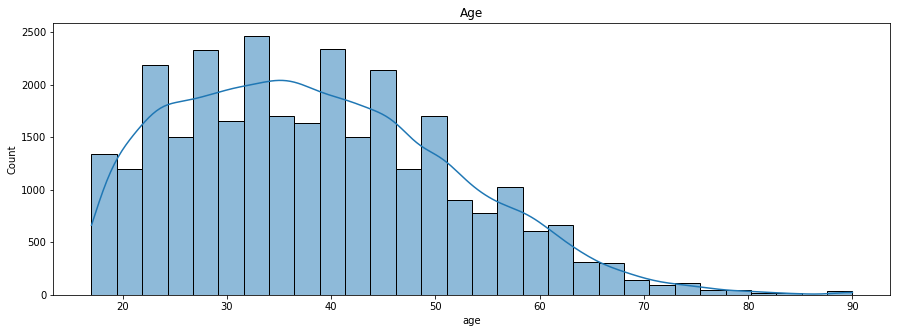

Age Skewness value :  0.5227354983362361


In [100]:
plt.figure(figsize = (15, 5))
sns.histplot(data['age'], bins=30, kde=True)
plt.title('Age')
plt.show()
print('Age Skewness value : ', data['age'].skew())

Visual di atas menunjukan bahwa data kita **mayoritas** berisi orang berumur **17-50 tahun** dan mulai menurun jumlahnya di atas umur 50-99 tahun.

## Working Hours

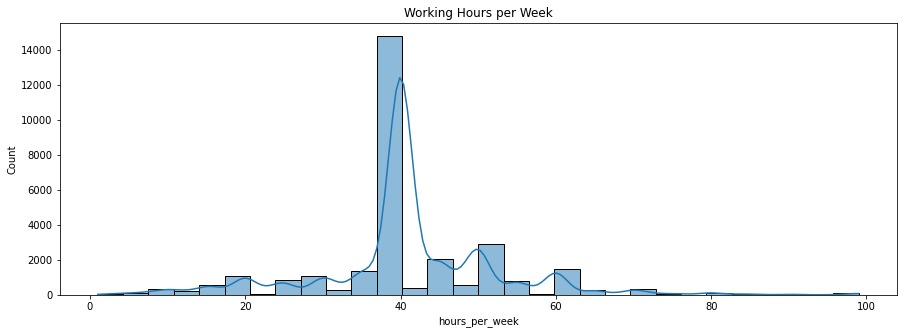

Working Hours Skewness value :  0.3319980582129928


In [101]:
plt.figure(figsize = (15, 5))
sns.histplot(data['hours_per_week'], bins=30, kde=True)
plt.title('Working Hours per Week')
plt.show()
print('Working Hours Skewness value : ', data['hours_per_week'].skew())

Visual di atas menunjukan bahwa sekitar **50%** orang pada data kita bekerja selama **40 jam seminggu** walaupun ada juga beberapa orang yang bekerja dengan jam kerja lebih sedikit ataupun lebih banyak.

## Education

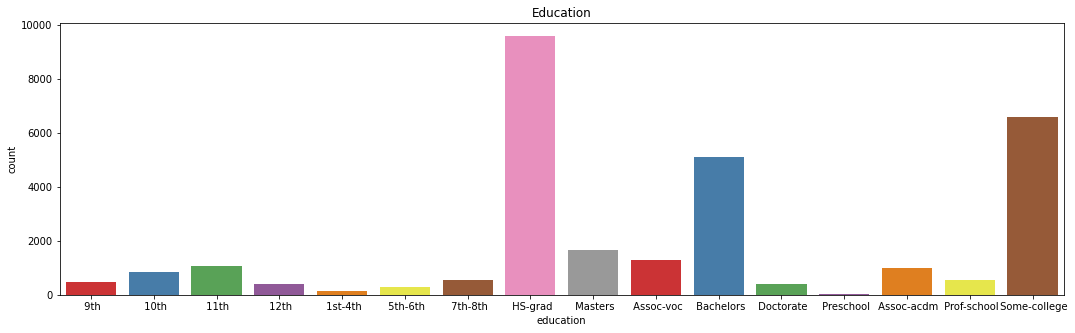

In [102]:
plt.figure(figsize=(18,5))
sns.countplot(x='education', data=data, palette='Set1')
plt.title('Education')
plt.show()

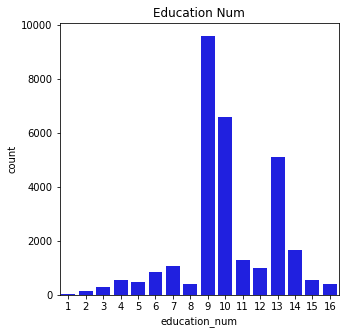

Education Num Skewness value :  -0.3070833618798013


In [103]:
plt.figure(figsize=(5,5))
sns.countplot(x='education_num', data=data, color='b')
plt.title('Education Num')
plt.show()
print('Education Num Skewness value : ', data['education_num'].skew())

Koresponden dalam data kita ternyata yang **paling banyak** adalah merupakah **lulusan SMA**, selanjutnya disusul dengan some-college atau vokasi, dan setelah itu disusul oleh lulusan sarjana. Kita bisa lihat orang yang memiliki pendapatan **rata-rata** sudah mengenyam pendidikan selama **9-10 tahun** meskipun banyak juga yang mengenyam pendidikan hingga 16 tahun lamanya.

## Workclass

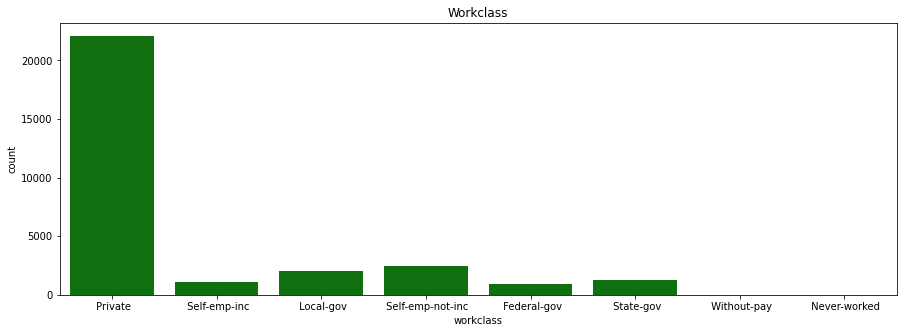

In [104]:
plt.figure(figsize=(15,5))
sns.countplot(x='workclass', data=data, color='g')
plt.title('Workclass')
plt.show()

In [105]:
data['workclass'].value_counts()

 Private             22085
 Self-emp-not-inc     2498
 Local-gov            2057
 State-gov            1276
 Self-emp-inc         1109
 Federal-gov           939
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

Data di atas menunjukan bahwa mayoritas orang dalam data kita bekerja di bidang **private(swasta)**, yaitu sebanyak 22085 atau sekitar **73%**. Sisanya ada yang bekerja di bawah pemerintah, ada yang berbisnis, ada yang tidak di gaji, dan bahkan ada yang tidak pernah bekerja.

## Occupation

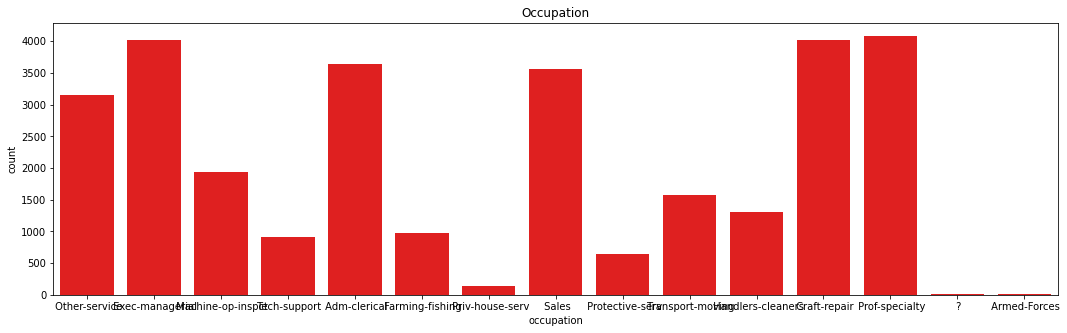

In [106]:
plt.figure(figsize=(18,5))
sns.countplot(x='occupation', data=data, color='r')
plt.title('Occupation')
plt.show()

In [107]:
data['occupation'].value_counts()

 Prof-specialty       4083
 Craft-repair         4025
 Exec-managerial      4021
 Adm-clerical         3646
 Sales                3563
 Other-service        3159
 Machine-op-inspct    1942
 Transport-moving     1577
 Handlers-cleaners    1303
 Farming-fishing       974
 Tech-support          906
 Protective-serv       637
 Priv-house-serv       135
 ?                       7
 Armed-Forces            7
Name: occupation, dtype: int64

Data di atas menunjukan bahwa ada beragam pekerjaan di Amerika. Ada 3 pekerjaan yang mendominasi dengan jumlah di atas 4000 orang yaitu Prof-specialty, Craft-repair, dan Exec-managerial.

## Capital Gain and Capital Loss

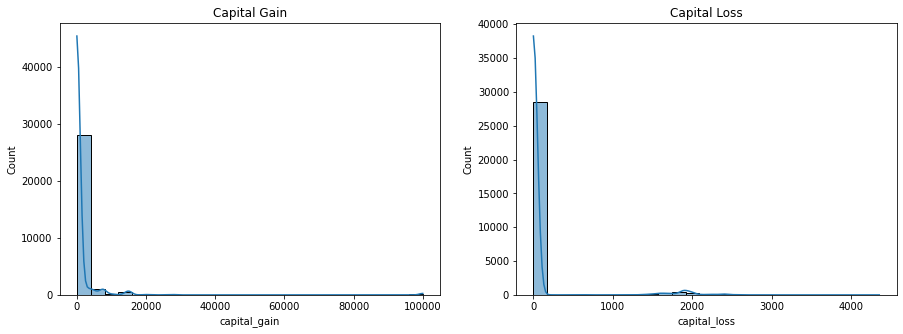

Capital Gain Skewness value :  11.669842506197968
Capital Loss Skewness value :  4.480136909348007


In [108]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['capital_gain'], bins=25, kde=True)
plt.title('Capital Gain')

plt.subplot(1, 2, 2)
sns.histplot(data['capital_loss'], bins=25, kde=True)
plt.title('Capital Loss')
plt.show()

print('Capital Gain Skewness value : ', data['capital_gain'].skew())
print('Capital Loss Skewness value : ', data['capital_loss'].skew())

Capital Gain dan Capital Loss kebanyakan bernilai 0 karena tidak semua orang pernah menjual aset kepemilikanya sehingga mendapatkan untung/rugi meskipun ada sedikit orang yang pernah mendapatkan untung/rugi yang lumayan besar.

## Relationship and Marital Status

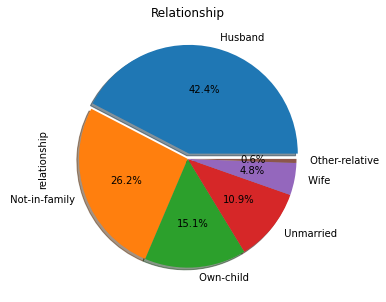

In [109]:
plt.figure(figsize=(5,5))
data['relationship'].value_counts().plot(kind='pie', explode=[0.05, 0, 0, 0 ,0 ,0], autopct='%1.1f%%', shadow=True)
plt.title('Relationship')
plt.show()

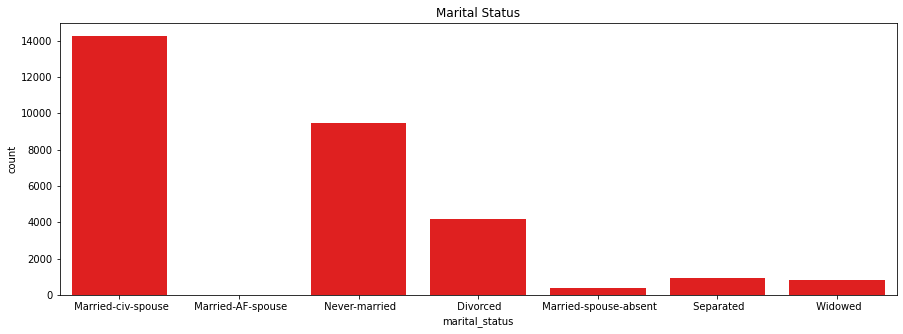

In [110]:
plt.figure(figsize=(15,5))
sns.countplot(x='marital_status', data=data, color='r')
plt.title('Marital Status')
plt.show()

In [111]:
data['marital_status'].value_counts()

 Married-civ-spouse       14250
 Never-married             9460
 Divorced                  4168
 Separated                  915
 Widowed                    806
 Married-spouse-absent      366
 Married-AF-spouse           20
Name: marital_status, dtype: int64

Sebanyak **42.4%** koresponden pada data kita merupakan seorang **suami**, artinya di dalam keluarga Amerika kebanyakan sang suamilah yang bekerja dan memiliki pendapatan.Data juga menunjukan bahwa **hampir 50%** orang dalam data kita dalam status **pernikahan(sipil)** dimana sisanya ada yang belum menikah, ada yang sudah bercerai, ada yang sudah berpisah, ada yang sudah janda/duda, ada yang menikah namun tidak tinggal serumah, dan ada juga yang menikah(tentara).

## Race and Gender

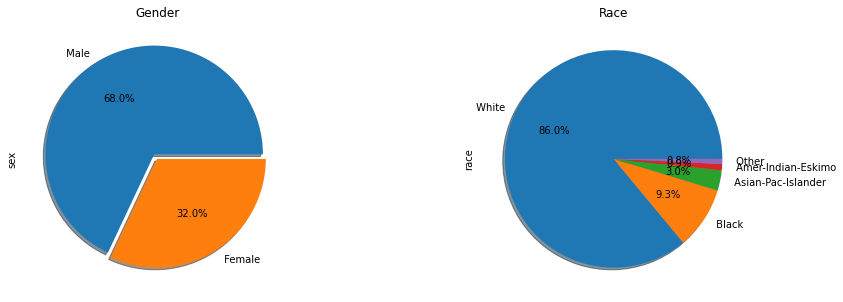

In [112]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
data['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=[0.05, 0], shadow=True)
plt.title('Gender')

plt.subplot(1, 2, 2)
data['race'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True)
plt.title('Race')
plt.show()

Visual di atas menunjukan bahwa 68% responden adalah pria, dan 32% sisanya adalah wanita. Data kita juga mencatat ada berbagai ras dimana didominasi oleh kulit putih sebanyak 86% dan sisanya ada kulit hitam, ada orang keturunan America-Asia, ada orang keturunan America-Indian-Eskimo, dan ada juga lainnya.

## Country

In [113]:
data['native_country'].unique()

array([' United-States', ' Portugal', ' Yugoslavia', ' Haiti',
       ' Dominican-Republic', ' Mexico', ' Guatemala', ' ?', ' Japan',
       ' Hong', ' Philippines', ' El-Salvador', ' Vietnam', ' Italy',
       ' Laos', ' Canada', ' Puerto-Rico', ' Jamaica', ' South',
       ' Trinadad&Tobago', ' Greece', ' Peru', ' Iran', ' Germany',
       ' Columbia', ' Scotland', ' China', ' Nicaragua', ' Cuba',
       ' England', ' Poland', ' Outlying-US(Guam-USVI-etc)', ' Taiwan',
       ' Hungary', ' India', ' Ecuador', ' Thailand', ' Cambodia',
       ' Honduras', ' France', ' Ireland'], dtype=object)

In [114]:
data['native_country'] = data['native_country'].replace([' ?'],' Unknown')

In [115]:
data['native_country'].value_counts()

 United-States                 26963
 Mexico                          571
 Unknown                         528
 Philippines                     172
 Germany                         127
 Canada                          106
 Puerto-Rico                     104
 India                            94
 El-Salvador                      92
 Cuba                             90
 England                          86
 Jamaica                          71
 Italy                            67
 China                            65
 South                            64
 Dominican-Republic               61
 Japan                            58
 Columbia                         55
 Guatemala                        55
 Vietnam                          54
 Poland                           53
 Taiwan                           41
 Iran                             41
 Portugal                         34
 Haiti                            33
 Greece                           28
 Peru                             28
 

Data di atas menunjukan bahwa mayoritas koresponden adalah orang Amerika dengan jumlah sebanyak 26963 orang atau sekitar 89% dan sisanya adalah dari negara lain di luar Amerika.

## Income (Target)

In [116]:
# Mencoba melihat jumlah target

data['income_bracket'].value_counts()

 <=50K    22370
 >50K      7615
Name: income_bracket, dtype: int64

Dari data di atas kita bisa lihat bahwa 22370 orang atau 74% orang Amerika memiliki pendapatan di atas 50 ribu dollar per tahun dan sisanya memiliki pendapatan di bawah 50 ribu dollar per tahun. Hal ini juga menunjukan bahwa data terget kita imbalance atau tidak seimbang.

## Correlation Between Columns

Selanjutnya kita ingin mengecek korelasi antar column.

In [117]:
# Memisahkan kolom numeric dan categotical
num_columns = data.select_dtypes(include=np.number).columns.tolist()
cat_columns = data.select_dtypes(include=['object']).columns.tolist()

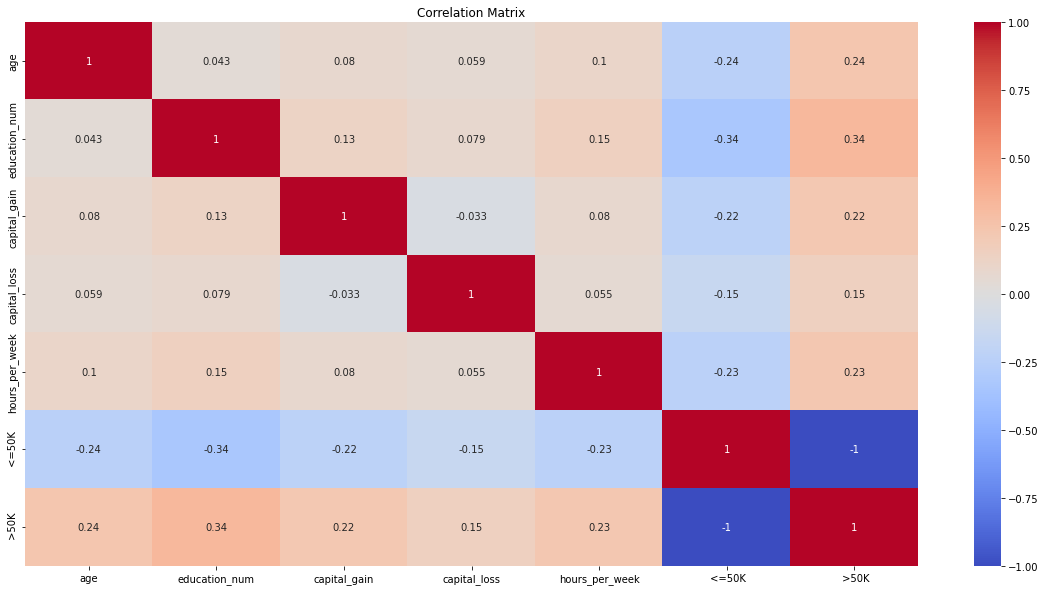

In [118]:
corr1 = pd.concat([data, pd.get_dummies(data.income_bracket)], axis=1).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr1, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Dari heatmap di atas kita bisa melihat bahwa `income_bracket` memiliki korelasi dengan beberapa kolom, namun saya hanya akan memilih kolom dengan nilai korelasi di atas 0.20 saja. Jadi semua kolom akan dipilih kecuali kolom `capital_loss`.

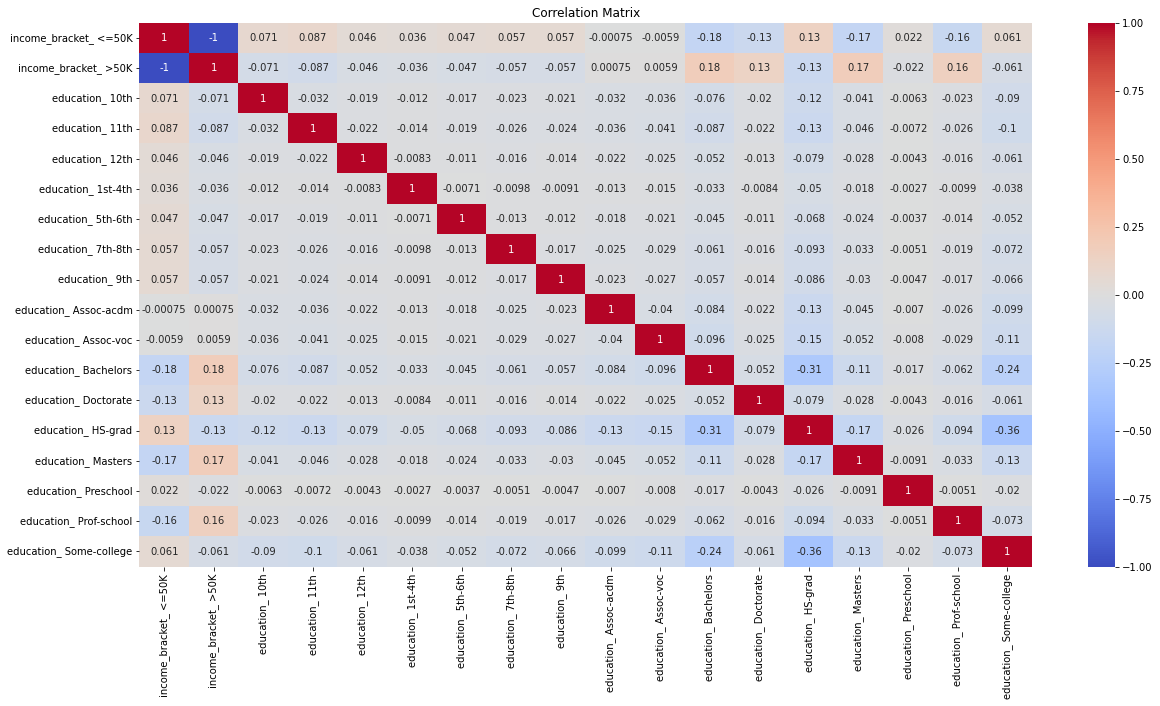

In [119]:
corr2 = pd.get_dummies(data[['income_bracket', 'education']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Karena tidak ada korelasi yang tinggi dengan `income_bracket` maka kita tidak akan menggunakan kolom `education`.

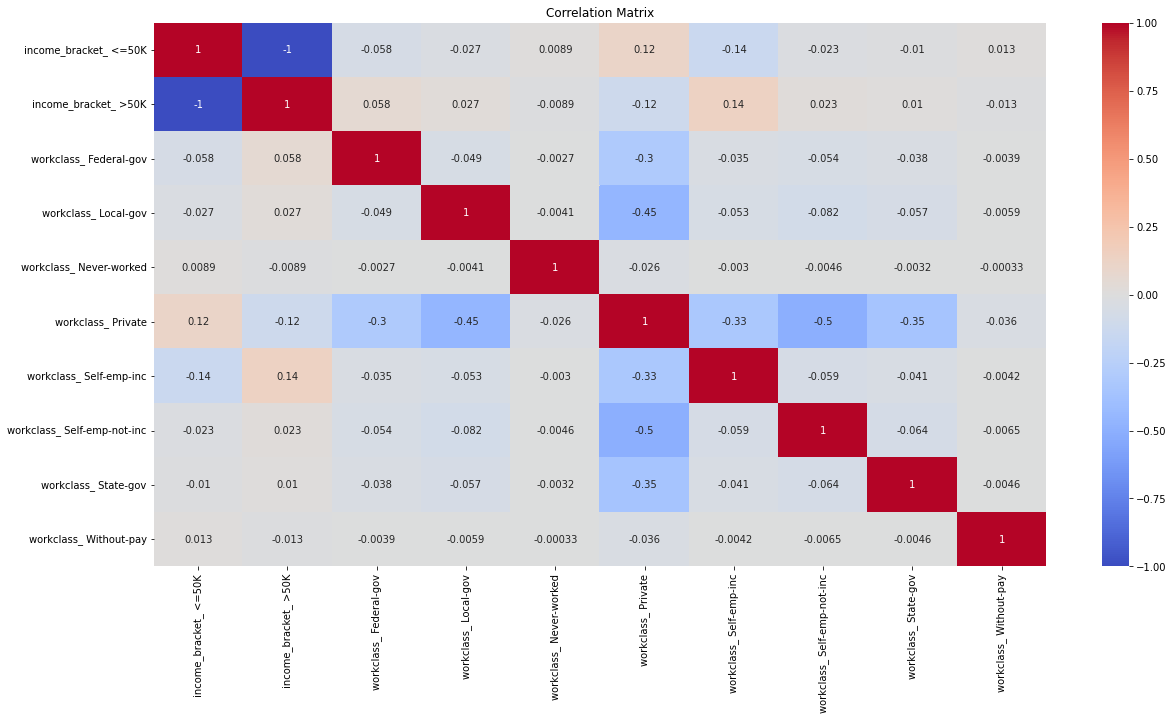

In [120]:
corr3 = pd.get_dummies(data[['income_bracket', 'workclass']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr3, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Karena tidak ada korelasi yang tinggi dengan `income_bracket` maka kita tidak akan menggunakan kolom `workclass`.

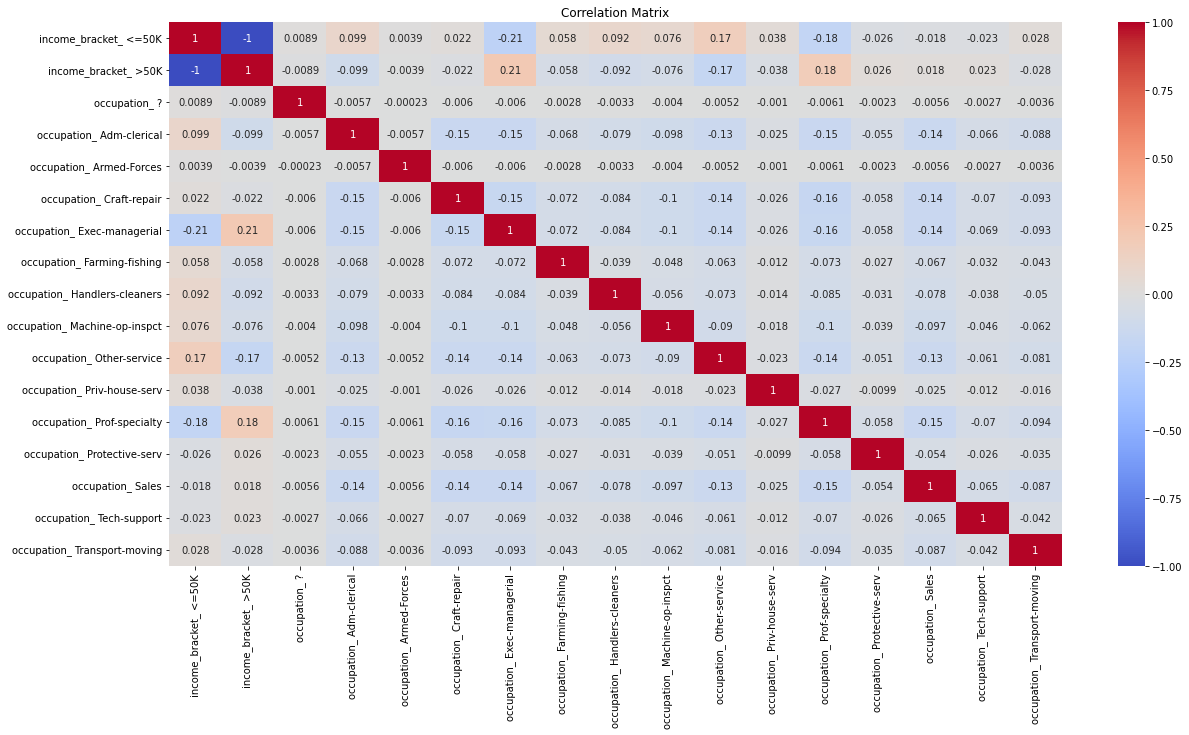

In [121]:
corr3 = pd.get_dummies(data[['income_bracket', 'occupation']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr3, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Karena kurang ada korelasi dengan kolom `income_bracket` maka kita tidak akan menggunakan `occupation`.

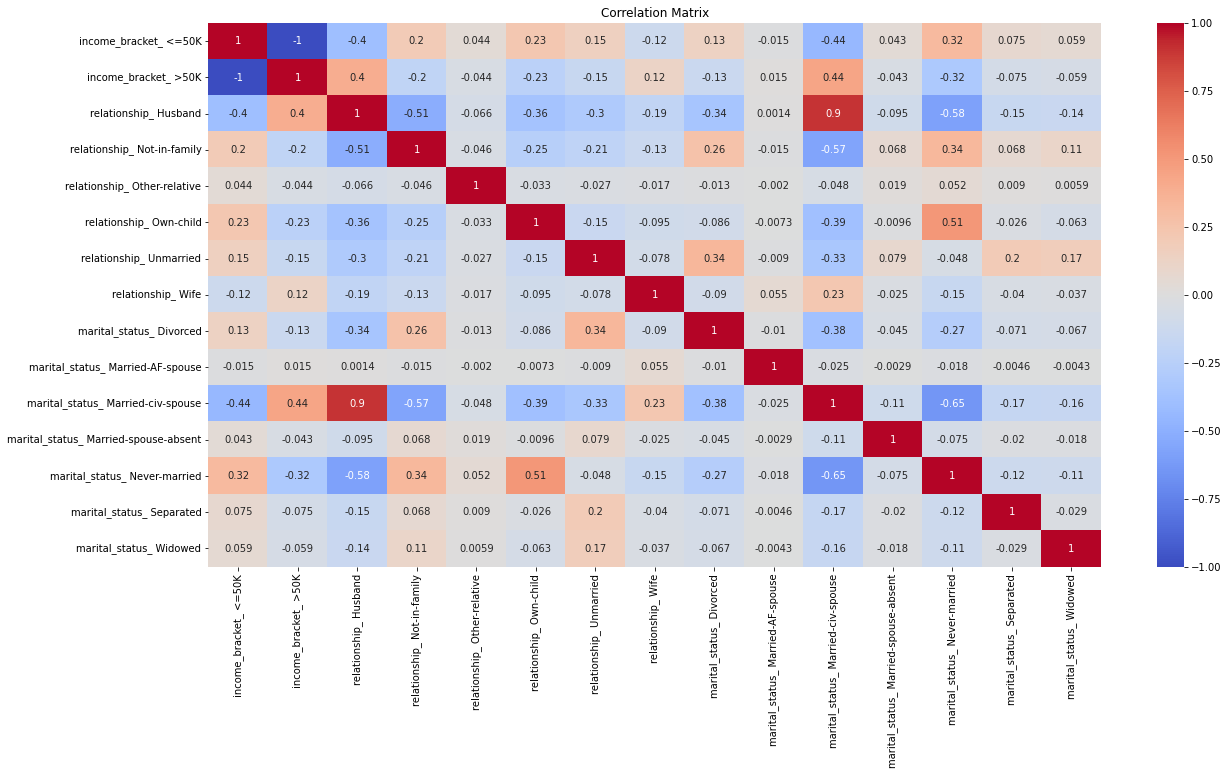

In [122]:
corr4 = pd.get_dummies(data[['income_bracket', 'relationship', 'marital_status']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr4, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Ada beberapa golongan `relationship` dan `marital_status` yang memiliki korelasi di atas 0.20 dengan `income_bracket` namun menurut personal judgement saya `marital_status` tidak mempengaruhi penghasilan seseorang sedangkan `relationship` cukup mempengaruhi karena akan berbeda penghasilan seorang suami yang harus menghidupi keluarga dengan seseorang yang mungkin belum menikah atau tidak punya keluarga. Jadi kolom `marital_status` tidak akan kita gunakan nanti.

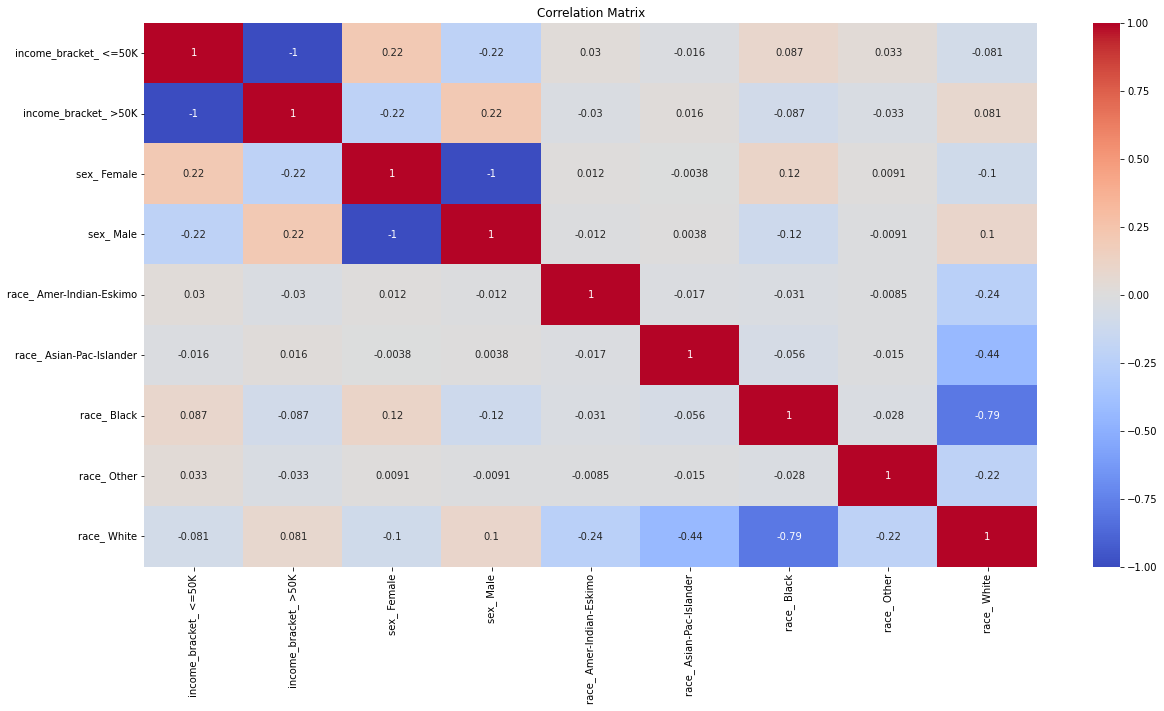

In [123]:
corr5 = pd.get_dummies(data[['income_bracket', 'sex', 'race']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr5, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Hanya kolom `sex` yang memiliki korelasi di atas 0.20, maka kita tidak akan menggunakan kolom `race`.

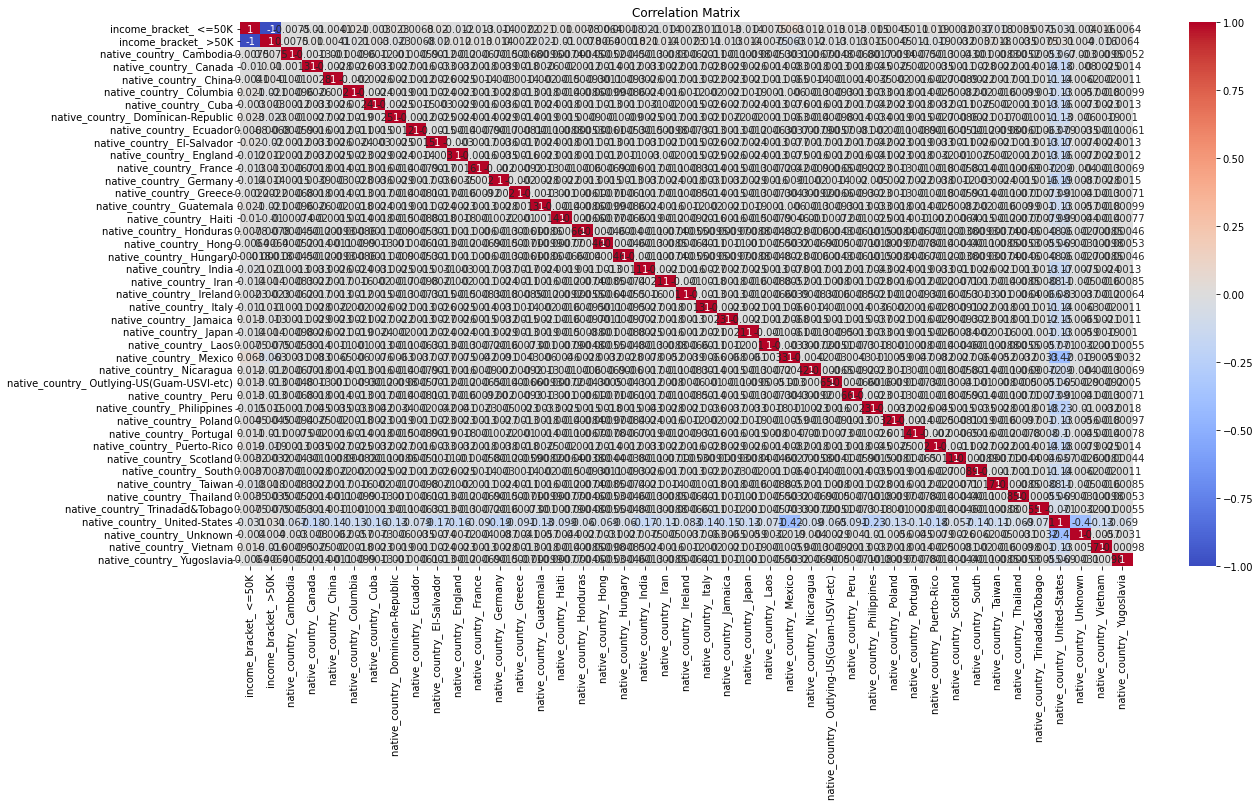

In [124]:
corr6 = pd.get_dummies(data[['income_bracket', 'native_country']]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr6, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Ternyata `native_country` tidak mempengaruhi `income_bracket`, jadi kita tidak akan menggunakan kolom tersebut.

# 5 - Data Preprocessing

## Get data for model inference

In [125]:
# Membuat data inference

data_inf = data.sample(10, random_state=17)
data_inf

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
2753,43,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
19889,43,Private,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,45,United-States,<=50K
18501,20,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,United-States,<=50K
9743,39,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
1413,37,Private,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,5013,0,40,United-States,<=50K
1670,54,Self-emp-not-inc,10th,6,Married-civ-spouse,Sales,Husband,White,Male,0,0,65,United-States,<=50K
26501,41,State-gov,Bachelors,13,Never-married,Protective-serv,Not-in-family,Black,Male,0,1590,40,Puerto-Rico,<=50K
11901,52,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
17119,26,State-gov,Assoc-acdm,12,Never-married,Adm-clerical,Own-child,Black,Female,0,0,8,United-States,<=50K
23328,29,Private,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [126]:
# Menghapus inference set dari dataset awal

data = data.drop(data_inf.index)
data

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29980,22,Private,5th-6th,3,Never-married,Farming-fishing,Other-relative,White,Male,0,0,40,Mexico,<=50K
29981,22,Private,5th-6th,3,Married-civ-spouse,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,<=50K
29982,18,Private,5th-6th,3,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,30,Honduras,<=50K
29983,53,Private,5th-6th,3,Married-civ-spouse,Other-service,Other-relative,White,Female,0,0,24,Italy,<=50K


In [127]:
# Reset index pada data Inference

data_inf.reset_index(drop=True, inplace=True)
data_inf

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,43,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
1,43,Private,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,45,United-States,<=50K
2,20,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,United-States,<=50K
3,39,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
4,37,Private,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,5013,0,40,United-States,<=50K
5,54,Self-emp-not-inc,10th,6,Married-civ-spouse,Sales,Husband,White,Male,0,0,65,United-States,<=50K
6,41,State-gov,Bachelors,13,Never-married,Protective-serv,Not-in-family,Black,Male,0,1590,40,Puerto-Rico,<=50K
7,52,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
8,26,State-gov,Assoc-acdm,12,Never-married,Adm-clerical,Own-child,Black,Female,0,0,8,United-States,<=50K
9,29,Private,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K


## Splitting Between Train-Set and Test-Set

Kita akan memisahkan data menjadi Train-Set dan juga Test-Set

In [128]:
# Splitting between `X` (Features) and `y` (Targets)

X = data.drop('income_bracket', axis=1)
y = data['income_bracket']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17, stratify=data.income_bracket)

print("Train Size : ", X_train.shape)
print("Test Size : ", X_test.shape)

Train Size :  (26977, 13)
Test Size :  (2998, 13)


## Handling Missing Values

### Train_set

In [130]:
# Mengecek jumlah missing value tiap kolom pada Train-Set

X_train.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [131]:
y_train.isnull().sum()

0

Kita bisa melihat bahwa tidak ada missing values pada Train Set, selanjutnya kita akan mengecek Test-Set.

### Test-Set

In [132]:
# Mengecek jumlah missing value tiap kolom pada Train-Set

X_test.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [133]:
y_test.isnull().sum()

0

Kita bisa melihat bahwa pada Test-Set juga tidak ada missing values, maka kita bisa melanjutkan ke tahap selanjutnya.

## Handling Outliers

### Check Distribution

In [134]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

    print(variable, 'skewness value : ', df[variable].skew())

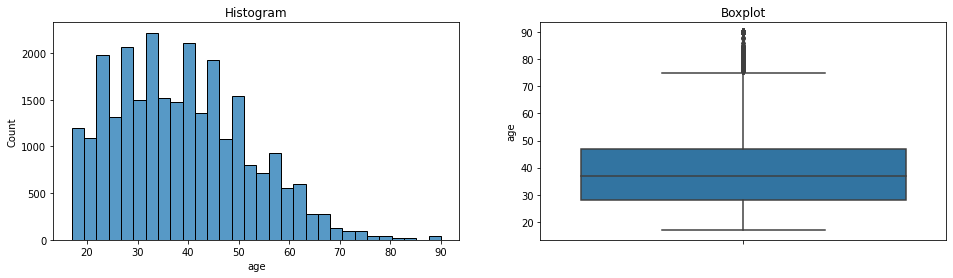

age skewness value :  0.5178645912120465


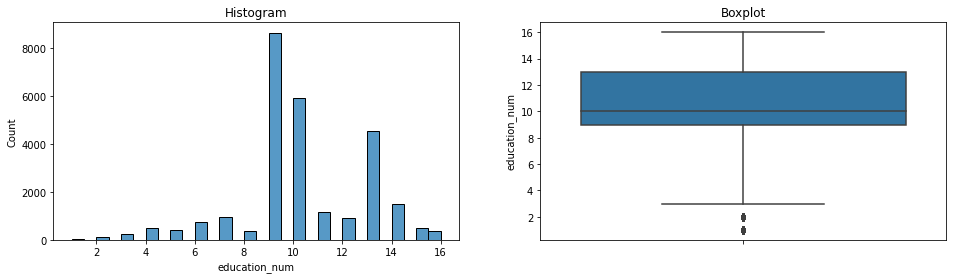

education_num skewness value :  -0.30658929989587475


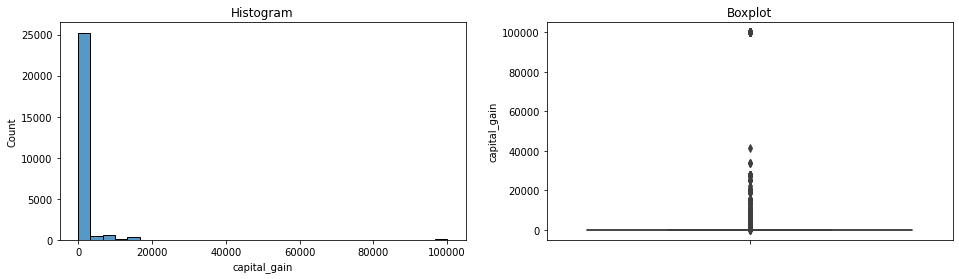

capital_gain skewness value :  11.714667367073226


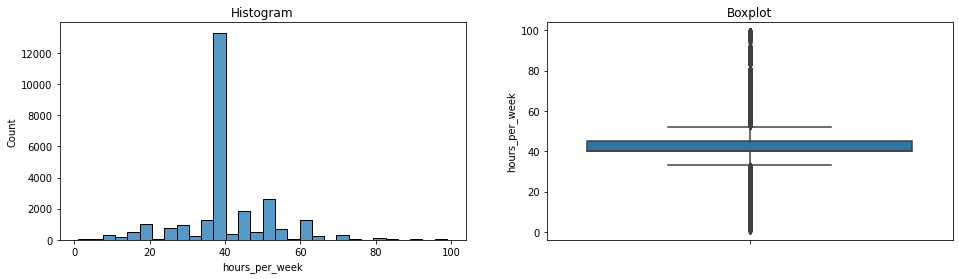

hours_per_week skewness value :  0.33209521557650895


In [135]:
diagnostic_plots(X_train, 'age')
diagnostic_plots(X_train, 'education_num')
diagnostic_plots(X_train, 'capital_gain')
diagnostic_plots(X_train, 'hours_per_week')

Semua kolom di atas memiliki outliers yang akan kita handling, namun kita akan melakukan handling sesuai dengan tipe distribusi datanya. 

*   `age` bertipe skewed dan akan dihandling dengan *IQR*
*   `education_num` dan `hours_per_week` bertipe normal dan akan dihandling dengan *mean* dan *std*

Untuk kolom `capital_gain` menurut saya tidak perlu dilakukan handling outliers karena data tersebut cukup penting karena keuntungan penjualan aset akan mempengaruhi penghasilan kita, terlebih lagi banyak orang yang belum pernah menjual asetnya.

### Count Outliers

In [136]:
def find_normal_boundaries(df, variable): # untuk distribusi normal
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [137]:
# Mengecek jumlah outliers education_num

upper_boundary, lower_boundary = find_normal_boundaries(X_train, 'education_num')

print('Jumlah Data Train: {}'.format(len(X_train)))
print('Jumlah data di luar upper boundary : {}'.format(len(X_train[X_train['education_num'] > upper_boundary])))
print('Jumlah data di luar lower boundary : {}'.format(len(X_train[X_train['education_num'] < lower_boundary])))
print('')
print('% upper boundary outliers : {}'.format(len(X_train[X_train['education_num'] > upper_boundary]) / len(X_train) * 100))
print('% lower boundary outliers  : {}'.format(len(X_train[X_train['education_num'] < lower_boundary]) / len(X_train) * 100))

Jumlah Data Train: 26977
Jumlah data di luar upper boundary : 0
Jumlah data di luar lower boundary : 181

% upper boundary outliers : 0.0
% lower boundary outliers  : 0.670941913481855


In [138]:
# Mengecek jumlah outliers hours_per_week

upper_boundary, lower_boundary = find_normal_boundaries(X_train, 'hours_per_week')

print('Jumlah Data Train: {}'.format(len(X_train)))
print('Jumlah data di luar upper boundary : {}'.format(len(X_train[X_train['hours_per_week'] > upper_boundary])))
print('Jumlah data di luar lower boundary : {}'.format(len(X_train[X_train['hours_per_week'] < lower_boundary])))
print('')
print('% upper boundary outliers : {}'.format(len(X_train[X_train['hours_per_week'] > upper_boundary]) / len(X_train) * 100))
print('% lower boundary outliers  : {}'.format(len(X_train[X_train['hours_per_week'] < lower_boundary]) / len(X_train) * 100))

Jumlah Data Train: 26977
Jumlah data di luar upper boundary : 293
Jumlah data di luar lower boundary : 96

% upper boundary outliers : 1.0861103903325053
% lower boundary outliers  : 0.3558586944434147


Menggunakan Extreme Values Analysis kita bisa lihat bahwa persentase outliers pada `education_num` hanya **0.67%** dan `hours_per_week` hanya **1.34%**. Berarti yang kita temukan benar outliers karena jumlahnya sedikit.

In [139]:
def find_skewed_boundaries(df, variable, distance): # untuk distribusi skewed
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [140]:
# Mengecek jumlah outliers capital_gain

upper_boundary, lower_boundary = find_skewed_boundaries(X_train, 'capital_gain', 1.5)

print('Jumlah Data Train: {}'.format(len(X_train)))
print('Jumlah data di luar upper boundary : {}'.format(len(X_train[X_train['capital_gain'] > upper_boundary])))
print('Jumlah data di luar lower boundary : {}'.format(len(X_train[X_train['capital_gain'] < lower_boundary])))
print('')
print('% upper boundary outliers : {}'.format(len(X_train[X_train['capital_gain'] > upper_boundary]) / len(X_train) * 100))
print('% lower boundary outliers  : {}'.format(len(X_train[X_train['capital_gain'] < lower_boundary]) / len(X_train) * 100))

Jumlah Data Train: 26977
Jumlah data di luar upper boundary : 2292
Jumlah data di luar lower boundary : 0

% upper boundary outliers : 8.496126329836526
% lower boundary outliers  : 0.0


In [141]:
# Mengecek jumlah outliers age

upper_boundary, lower_boundary = find_skewed_boundaries(X_train, 'age', 1.5)

print('Jumlah Data Train: {}'.format(len(X_train)))
print('Jumlah data di luar upper boundary : {}'.format(len(X_train[X_train['age'] > upper_boundary])))
print('Jumlah data di luar lower boundary : {}'.format(len(X_train[X_train['age'] < lower_boundary])))
print('')
print('% upper boundary outliers : {}'.format(len(X_train[X_train['age'] > upper_boundary]) / len(X_train) * 100))
print('% lower boundary outliers  : {}'.format(len(X_train[X_train['age'] < lower_boundary]) / len(X_train) * 100))

Jumlah Data Train: 26977
Jumlah data di luar upper boundary : 152
Jumlah data di luar lower boundary : 0

% upper boundary outliers : 0.56344293286874
% lower boundary outliers  : 0.0


Menggunakan IQR kita bisa lihat bahwa persentase outliers pada `age` hanya **0.57%** dan `capital_gain` mencapai **8.54%**. Seperti yang dibilang di atas, mayoritas orang belum pernah menjual asetnya, maka dari itu banyak dari `capital_gain` yang bernilai 0, dan yang pernah menjual asetnya termasuk outliers dimana tidak akan kita handling karena merupakan data penting menurut saya. Selanjutnya `age` akan kita handling menggunakan capping.

### Capping

In [142]:
# Membuat capper IQR

windsoriser_iqr = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['age'])

windsoriser_iqr.fit(X_train)

X_train_capped_iqr = windsoriser_iqr.transform(X_train)
X_test_capped_iqr = windsoriser_iqr.transform(X_test)

In [143]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', windsoriser_iqr.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', windsoriser_iqr.right_tail_caps_)

Left Tail Caps  :  {'age': -0.5}
Right Tail Caps :  {'age': 75.5}


In [144]:
print('X_train - Before Capping')
print(X_train.describe())
print('')
print('X_train - After Capping')
print(X_train_capped_iqr.describe())
print('')
print('X_test - Before Capping')
print(X_test.describe())
print('')
print('X_test - After Capping')
print(X_test_capped_iqr.describe())

X_train - Before Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  26977.000000   26977.000000  26977.000000  26977.000000    26977.000000
mean      38.588872      10.143530   1119.271787     88.802017       41.011788
std       13.099012       2.571099   7545.311612    405.293079       11.998422
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

X_train - After Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  26977.000000   26977.000000  26977.000000  26977.000000    26977.000000
mean      38.553842      10.143530   1119.271787     88.802017       41.011788
st

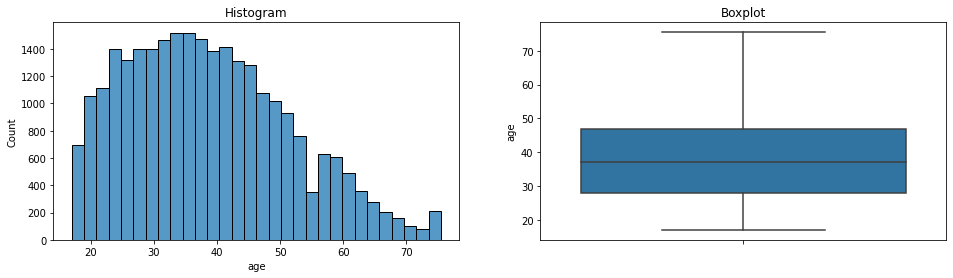

age skewness value :  0.45366578481781694


In [145]:
diagnostic_plots(X_train_capped_iqr, 'age')

Sekarang sudah tidak ada lagi outliers pada kolom `age`.

In [146]:
# Membuat capper IQR

windsoriser = Winsorizer(capping_method='gaussian', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['education_num', 'hours_per_week'])

windsoriser.fit(X_train_capped_iqr)

X_train_capped_final = windsoriser.transform(X_train_capped_iqr)
X_test_capped_final = windsoriser.transform(X_test_capped_iqr)

In [147]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', windsoriser.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', windsoriser.right_tail_caps_)

Left Tail Caps  :  {'education_num': 2.43023149528776, 'hours_per_week': 5.016522656343746}
Right Tail Caps :  {'education_num': 17.85682785156326, 'hours_per_week': 77.00705298216312}


In [148]:
print('X_train - Before Capping')
print(X_train_capped_iqr.describe())
print('')
print('X_train - After Capping')
print(X_train_capped_final.describe())
print('')
print('X_test - Before Capping')
print(X_test_capped_iqr.describe())
print('')
print('X_test - After Capping')
print(X_test_capped_final.describe())

X_train - Before Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  26977.000000   26977.000000  26977.000000  26977.000000    26977.000000
mean      38.553842      10.143530   1119.271787     88.802017       41.011788
std       12.985823       2.571099   7545.311612    405.293079       11.998422
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       75.500000      16.000000  99999.000000   4356.000000       99.000000

X_train - After Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  26977.000000   26977.000000  26977.000000  26977.000000    26977.000000
mean      38.553842      10.147899   1119.271787     88.802017       40.904461
st

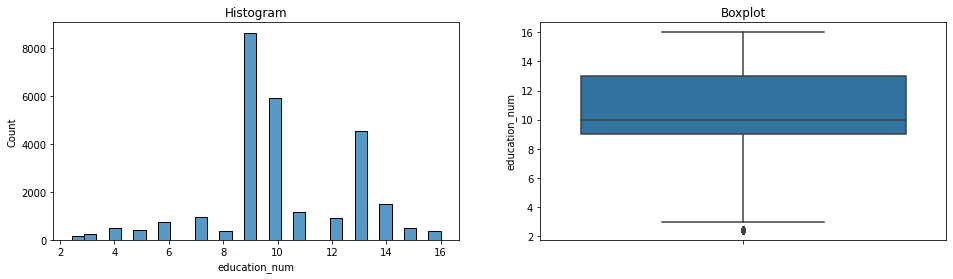

education_num skewness value :  -0.26428864524931994


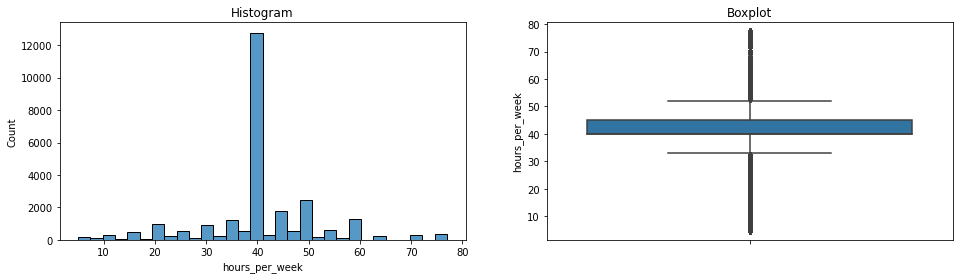

hours_per_week skewness value :  -0.022165987179943017


In [149]:
diagnostic_plots(X_train_capped_final, 'education_num')
diagnostic_plots(X_train_capped_final, 'hours_per_week')

Kita bisa lihat outliers pada `education_num` dan `hours_per_week` sudah berkurang namun tetap masih ada outliers karena setelah melakukan capping maka paramaterer dari data seperti mean, quantiles dan inter-quantile akan berubah lagi menyesuaikan data yang baru. 

## Features Selection

Kita akan memilih feature yang akan digunakan dengan sesuai perhitungan korelasi antar kolom dan juga personal judgement yang sudah dilakukan di EDA.

In [150]:
X_train_ = X_train_capped_final[['age', 'education_num', 'capital_gain', 'hours_per_week', 'sex', 'relationship']]
X_test_ = X_test_capped_final[['age', 'education_num', 'capital_gain', 'hours_per_week', 'sex', 'relationship']]
X_train_

,age,education_num,capital_gain,hours_per_week,sex,relationship
10621,39.0,13.0,0,40.0,Male,Husband
28122,26.0,10.0,0,35.0,Female,Not-in-family
25690,25.0,11.0,0,40.0,Female,Not-in-family
16322,21.0,9.0,0,60.0,Male,Own-child
16191,23.0,9.0,0,40.0,Male,Own-child
...,...,...,...,...,...,...
42,25.0,6.0,0,40.0,Female,Wife
3658,38.0,9.0,0,60.0,Male,Husband
26931,38.0,13.0,0,45.0,Male,Not-in-family
25775,52.0,11.0,0,40.0,Female,Not-in-family


Setelah mendapatkan kolom feature yang diinginkan, selanjutkan akan dilakukan scaling dan encoding.

## Split between Numerical Columns and Categorical Columns

In [151]:
# Mendapatkan list Numerical columns dan Categorical columns

num_cols = X_train_.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train_.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_cols)
print('Categorical Columns : ', cat_cols)

Numerical Columns :  ['age', 'education_num', 'capital_gain', 'hours_per_week']
Categorical Columns :  ['sex', 'relationship']


In [152]:
# Memisahkan Train-set and Test-set berdasarkan tipe kolomnya

X_train_num = X_train_[num_cols]
X_train_cat = X_train_[cat_cols]

X_test_num = X_test_[num_cols]
X_test_cat = X_test_[cat_cols]

## Features Scaling

Kita akan melakukan scaling pada kolom numeric di Train-Set yaitu kolom `age`, `education_num`, `capital_gain` dan `hours_per_week`

In [153]:
X_train_num

,age,education_num,capital_gain,hours_per_week
10621,39.0,13.0,0,40.0
28122,26.0,10.0,0,35.0
25690,25.0,11.0,0,40.0
16322,21.0,9.0,0,60.0
16191,23.0,9.0,0,40.0
...,...,...,...,...
42,25.0,6.0,0,40.0
3658,38.0,9.0,0,60.0
26931,38.0,13.0,0,45.0
25775,52.0,11.0,0,40.0


In [154]:
X_train_num.describe()

,age,education_num,capital_gain,hours_per_week
count,26977.000000,26977.000000,26977.000000,26977.000000
mean,38.553842,10.147899,1119.271787,40.904461
std,12.985823,2.557171,7545.311612,11.561615
min,17.000000,2.430231,0.000000,5.016523
25%,28.000000,9.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,45.000000
max,75.500000,16.000000,99999.000000,77.007053


Untuk melakukan scaling kita harus tau data tersebut skewed atau tidak karena akan mempengaruhi pilihan metode scalingnya.

In [155]:
print('age skewness value : ', X_train_num['age'].skew())
print('education_num skewness value : ', X_train_num['education_num'].skew())
print('capital_gain skewness value : ', X_train_num['capital_gain'].skew())
print('hours_per_week skewness value : ', X_train_num['hours_per_week'].skew())

age skewness value :  0.45366578481781694
education_num skewness value :  -0.26428864524931994
capital_gain skewness value :  11.714667367073226
hours_per_week skewness value :  -0.022165987179943017


Setelah mengetahui persebaran data maka kita menentukan :

* `age`, `education_num`, dan `hours_per_week` akan menggunakan *StandardScaler* karena berdistribusi normal.
* `capital_gain` akan menggunakan MinMaxScaler karena berdistribusi skewed.

In [156]:
# Memisahkan data skewed dan data normal

X_train_num_normal = X_train_num[['age','education_num', 'hours_per_week']]
X_train_num_skewed = X_train_num[['capital_gain']]
X_test_num_normal = X_test_num[['age','education_num', 'hours_per_week']]
X_test_num_skewed = X_test_num[['capital_gain']]

In [157]:
# Feature scaling menggunakan MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_num_skewed) #.fit hanya di Train-Set

X_train_num_scaled_1 = scaler.transform(X_train_num_skewed)
X_test_num_scaled_1 = scaler.transform(X_test_num_skewed)

In [158]:
# Feature scaling menggunakan StandardScaler

scaler_ = StandardScaler()
scaler_.fit(X_train_num_normal) #.fit hanya di Train-Set

X_train_num_scaled_2 = scaler_.transform(X_train_num_normal)
X_test_num_scaled_2 = scaler_.transform(X_test_num_normal)
X_train_num_scaled_2

array([[ 0.03435794,  1.11535496, -0.07823112],
       [-0.96675234, -0.05783803, -0.51070466],
       [-1.04376083,  0.3332263 , -0.07823112],
       ...,
       [-0.04265054,  1.11535496,  0.35424243],
       [ 1.03546822,  0.3332263 , -0.07823112],
       [-0.35068448, -0.44890236, -0.07823112]])

Setelah mendapatkan hasil scaling maka akan kita ubah lagi menjadi bentuk dataframe.

In [159]:
# Mengembalikan ke bentuk dataframe
X_train_num_skewed_scaled = pd.DataFrame(X_train_num_scaled_1, columns=['capital_gain'])
X_test_num_skewed_scaled = pd.DataFrame(X_test_num_scaled_1, columns=['capital_gain'])
X_train_num_normal_scaled = pd.DataFrame(X_train_num_scaled_2, columns=['age','education_num', 'hours_per_week'])
X_test_num_normal_scaled = pd.DataFrame(X_test_num_scaled_2, columns=['age','education_num', 'hours_per_week'])

# Menyatukan data yang normal dan skewed
X_train_num_final = pd.concat([X_train_num_skewed_scaled, X_train_num_normal_scaled], axis=1)
X_test_num_final = pd.concat([X_test_num_skewed_scaled, X_test_num_normal_scaled], axis=1)
X_train_num_final

,capital_gain,age,education_num,hours_per_week
0,0.0,0.034358,1.115355,-0.078231
1,0.0,-0.966752,-0.057838,-0.510705
2,0.0,-1.043761,0.333226,-0.078231
3,0.0,-1.351795,-0.448902,1.651663
4,0.0,-1.197778,-0.448902,-0.078231
...,...,...,...,...
26972,0.0,-1.043761,-1.622095,-0.078231
26973,0.0,-0.042651,-0.448902,1.651663
26974,0.0,-0.042651,1.115355,0.354242
26975,0.0,1.035468,0.333226,-0.078231


## Feature Encoding

Karena kolom `sex` dan `relationship` tidak memiliki urutan/tingkatan maka kita akan melakukan encoding menggunakan *OneHotEncoder*.

In [160]:
# Feature encoding menggunakan OneHotEndoder

encoder = OneHotEncoder()
encoder.fit(X_train_cat) #.fit hanya di Train-Set

X_train_cat_encoded = encoder.transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

Setelah mendapatkan hasil encoding maka akan kita ubah lagi menjadi dataframe.

In [161]:
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded.toarray(), columns=encoder.get_feature_names(cat_cols))
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded.toarray(), columns=encoder.get_feature_names(cat_cols))
X_train_cat_encoded 

,sex_ Female,sex_ Male,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26972,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26973,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
26974,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
26975,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Concat between Numerical Columns and Categorical Columns

Menggabungkan hasil scaling dan encoding menjadi satu dataframe untuk di training.

In [162]:
# Concat Numerical Columns dan Categorical Columns

X_train_final = pd.concat([X_train_num_final, X_train_cat_encoded], axis=1)
X_test_final = pd.concat([X_test_num_final, X_test_cat_encoded], axis=1)
X_train_final

,capital_gain,age,education_num,hours_per_week,sex_ Female,sex_ Male,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.0,0.034358,1.115355,-0.078231,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.966752,-0.057838,-0.510705,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,-1.043761,0.333226,-0.078231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,-1.351795,-0.448902,1.651663,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,-1.197778,-0.448902,-0.078231,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26972,0.0,-1.043761,-1.622095,-0.078231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26973,0.0,-0.042651,-0.448902,1.651663,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
26974,0.0,-0.042651,1.115355,0.354242,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
26975,0.0,1.035468,0.333226,-0.078231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [163]:
X_test_final

,capital_gain,age,education_num,hours_per_week,sex_ Female,sex_ Male,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.00000,-1.043761,-0.057838,-0.078231,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.00000,0.342392,-0.448902,-0.078231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.00000,-1.120769,1.115355,-0.683694,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,-0.889744,-0.448902,-0.078231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.04064,-0.966752,1.115355,0.786716,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2993,0.00000,-1.043761,1.115355,-0.251221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2994,0.00000,-1.659829,-1.622095,-0.943178,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2995,0.00000,0.419400,0.724291,0.786716,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2996,0.00000,0.650426,-0.448902,-1.375652,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# 6 - Model Definition

Karena kasus kali ini adalah kasus klasifikasi maka kita akan menggunakan model yang khusus untuk klasifikasi dimana kita memilih Logistic Regression dan Support Vector Clasifier (SVC).

In [164]:
# Mendefinisikan model menggunakan Logistic Regression dan SVC

logistic = LogisticRegression()
svc = SVC(kernel='rbf', C=100)

# 7 - Model Training

In [165]:
# Training model

%time logistic.fit(X_train_final, y_train)
%time svc.fit(X_train_final, y_train)

CPU times: user 614 ms, sys: 329 ms, total: 943 ms
Wall time: 1.44 s
CPU times: user 56.3 s, sys: 151 ms, total: 56.5 s
Wall time: 57 s


SVC(C=100)

Kita bisa melihat waktu training yang dibutuhkan untuk train tiap model. Waktu untuk train model menggunakan SVC lebih lama daripada model logistic regression.

# 8 - Model Evaluation

Setelah melakukan training sekarang kita akan melakukan evaluasi terhadap model yang sudah kita train.

## Logistic Regression

In [166]:
print('----Training Set----')
print(classification_report(y_train, logistic.predict(X_train_final)))
print('----Testing Set----')
print(classification_report(y_test, logistic.predict(X_test_final)))

----Training Set----
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89     20125
        >50K       0.71      0.55      0.62      6852

    accuracy                           0.83     26977
   macro avg       0.79      0.74      0.76     26977
weighted avg       0.82      0.83      0.82     26977

----Testing Set----
              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      2237
        >50K       0.72      0.55      0.62       761

    accuracy                           0.83      2998
   macro avg       0.79      0.74      0.76      2998
weighted avg       0.82      0.83      0.82      2998



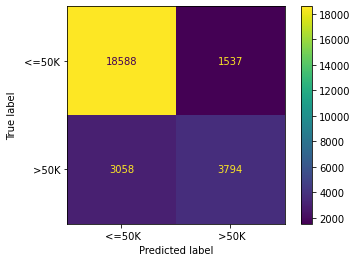

In [167]:
ConfusionMatrixDisplay.from_predictions(y_train, logistic.predict(X_train_final))
plt.show()

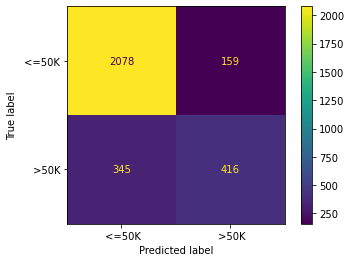

In [168]:
ConfusionMatrixDisplay.from_predictions(y_test, logistic.predict(X_test_final))
plt.show()

Dari kedua confusion matrix kita bisa melihat bahwa false negativenya sangat sedikit. Pada Train-Set, hanya ada 1537 salah prediksi untuk label <=50K dimana prediksi benarnya sebanyak 18588. Untuk Test-Set kita bisa lihat hanya ada salah prediksi sebanyak 159 di label <=50K dimana prediksi benarnya sebanyak 2078. Untuk label >50K kita bisa lihat ada salah prediksi sekitar 45% dikarenakan terjadi imbalance data dimana jumlah label >50K hanya sedikit jika dibandingkan dengan jumlah label <=50K.

## SVC

In [169]:
print('----Training Set----')
print(classification_report(y_train, svc.predict(X_train_final)))
print('----Testing Set----')
print(classification_report(y_test, svc.predict(X_test_final)))

----Training Set----
              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90     20125
        >50K       0.76      0.56      0.64      6852

    accuracy                           0.84     26977
   macro avg       0.81      0.75      0.77     26977
weighted avg       0.84      0.84      0.83     26977

----Testing Set----
              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90      2237
        >50K       0.76      0.54      0.63       761

    accuracy                           0.84      2998
   macro avg       0.81      0.74      0.76      2998
weighted avg       0.83      0.84      0.83      2998



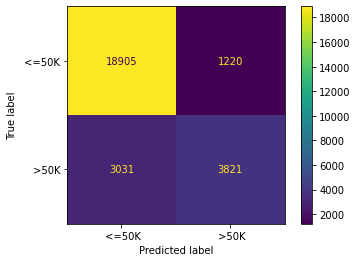

In [170]:
ConfusionMatrixDisplay.from_predictions(y_train, svc.predict(X_train_final))
plt.show()

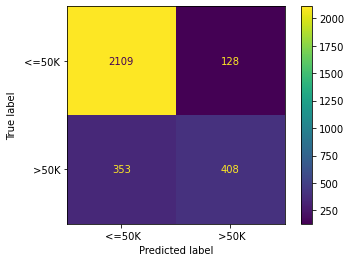

In [171]:
ConfusionMatrixDisplay.from_predictions(y_test, svc.predict(X_test_final))
plt.show()

Pada model SVC di kedua confusion matrix kita bisa melihat bahwa false negativenya lebih sedikit dibandingkan dengan model Logistic Regression. Pada Train-Set, hanya ada 1220 salah prediksi untuk label <=50K dimana prediksi benarnya sebanyak 18905. Untuk Test-Set kita bisa lihat hanya ada salah prediksi sebanyak 128 di label <=50K dimana prediksi benarnya sebanyak 2109. Sedangkan untuk label >50K kita bisa lihat ada salah prediksi sekitar 44% yang disebabkan oleh imbalance data.

## Model Analysis


Dalam kasus ini kita akan lebih **fokus ke label <=50K** karena merupakan orang yang pendapatanya di bawah rata-rata. Kita akan lebih fokus ke bagian recall untuk meminimalisir false negatif karena jika terjadi salah prediksi (false negatif) maka orang yang memiliki pendapatan di bawah rata-rata kemungkinan akan kesulitan jika harus membayar pajak sejumlah orang yang di atas rata-rata atau di atas 50 ribu dollar.

Dari kedua model diatas secara keseluruhan akurasi dari Logistic Regression dan Support Vector Classifier tidak memiliki perbedaan yang signifikan kedua sama-sama memiliki akurasi sebesar 0.84 namun karena data target kita imbalance, maka kita tidak boleh terpaku pada accuracy. Precision kedua model kita memiliki nilai yang cukup bagus dimana **Logistic** memiliki **precision 0.86** pada Train dan Test, sedangkan **SVC** memiliki precision **0.86** untuk Train dan **0.85** untuk Test. Kedua model kita juga memiliki recall yang tinggi untuk label <=50K dimana Logistic memiliki recall 0.92 pada Train dan 0.93 pada Test, sedangkan SVC memiliki recall 0.94 untuk Train dan Test. Kedua model kita memiliki recall yang rendah untuk label >50K, hal ini disebakan karena kedua model dilatih dengan data yang memiliki label imbalanced dimana jumlah label >50K tidak sampai setengah dari jumlah label <=50K. Jika target kita balance maka saya yakin nilai recallnya akan jadi lebih tinggi.



# 9 - Model Inference

## Inferencing

Sebelum melakukan evaluasi pada Inference Set, kita akan melakukan tahapan preprocessing yang sama dengan yang dilakukan pada Test-Set. Kita akan memisahkan kolom numerical dan categorical dan setelah itu akan dilakukan encoding dan scaling sebelum akhirnya akan disatukan lagi untuk dilakukan evaluasi.

In [172]:
# Memisahkan Numerical Columns dan Categorical Columns Data Inference

data_inf_num = data_inf[num_cols]
data_inf_cat = data_inf[cat_cols]

In [173]:
# Memisahkan data skewed dan normal

data_inf_num_normal = data_inf_num[['age','education_num', 'hours_per_week']]
data_inf_num_skewed = data_inf_num[['capital_gain']]

In [174]:
# Scaling dan Encoding pada Data Inference

data_inf_num_normal_scaled = scaler_.transform(data_inf_num_normal)
data_inf_num_skewed_scaled = scaler.transform(data_inf_num_skewed)
data_inf_cat_encoded = encoder.transform(data_inf_cat)

In [175]:
# Merubah kembali ke bentuk dataframe

data_inf_cat_encoded_df = pd.DataFrame(data_inf_cat_encoded.toarray(), columns=encoder.get_feature_names(cat_cols))
data_inf_num_skewed_scaled_df = pd.DataFrame(data_inf_num_skewed_scaled, columns=['capital_gain'])
data_inf_num_normal_scaled_df = pd.DataFrame(data_inf_num_normal_scaled, columns=['age','education_num', 'hours_per_week'])

In [176]:
# Concate Numerical Columns dan Categorical Columns

data_inf_final = pd.concat([data_inf_num_skewed_scaled_df, data_inf_num_normal_scaled_df, data_inf_cat_encoded_df], axis=1)
data_inf_final

,capital_gain,age,education_num,hours_per_week,sex_ Female,sex_ Male,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.000000,0.342392,-2.404224,0.354242,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.342392,-0.448902,0.354242,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,-1.428803,-0.057838,-2.240599,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.034358,1.115355,1.651663,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.050131,-0.119659,-0.057838,-0.078231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.000000,1.189485,-1.622095,2.084137,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.188375,1.115355,-0.078231,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.000000,1.035468,-0.057838,-0.078231,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,-0.966752,0.724291,-2.846062,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.000000,-0.735727,-0.448902,-0.078231,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [177]:
# Predict dengan model Linear Regression dan Linear Regression with Polynomial Features

y_pred_inf_log = logistic.predict(data_inf_final)
y_pred_inf_svc = svc.predict(data_inf_final)

In [178]:
# Merubah hasil predict ke dataframe

y_pred_inf_log_df = pd.DataFrame(y_pred_inf_log, columns=['Log_Pred'])
y_pred_inf_svc_df = pd.DataFrame(y_pred_inf_svc, columns=['SVC_Pred'])

In [179]:
# Membuat Dataframe Prediction

pred_inf = pd.concat([data_inf['income_bracket'], y_pred_inf_log_df, y_pred_inf_svc_df], axis=1)
pred_inf

,income_bracket,Log_Pred,SVC_Pred
0,<=50K,<=50K,<=50K
1,<=50K,<=50K,<=50K
2,<=50K,<=50K,<=50K
3,>50K,>50K,>50K
4,<=50K,>50K,>50K
5,<=50K,<=50K,<=50K
6,<=50K,<=50K,<=50K
7,>50K,<=50K,<=50K
8,<=50K,<=50K,<=50K
9,<=50K,<=50K,<=50K


Setelah mendapatkan hasil prediksi, kita bisa melakukan evaluasi model yang digunakan.

In [180]:
print('----Logistic----')
print(classification_report(data_inf['income_bracket'], y_pred_inf_log))
print('----SVC----')
print(classification_report(data_inf['income_bracket'], y_pred_inf_svc))

----Logistic----
              precision    recall  f1-score   support

       <=50K       0.88      0.88      0.88         8
        >50K       0.50      0.50      0.50         2

    accuracy                           0.80        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.80      0.80      0.80        10

----SVC----
              precision    recall  f1-score   support

       <=50K       0.88      0.88      0.88         8
        >50K       0.50      0.50      0.50         2

    accuracy                           0.80        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.80      0.80      0.80        10



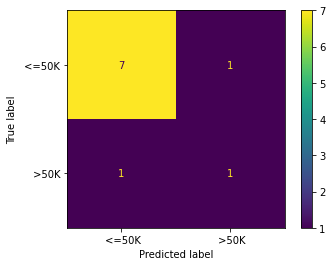

In [181]:
ConfusionMatrixDisplay.from_predictions(data_inf['income_bracket'], y_pred_inf_log)
plt.show()

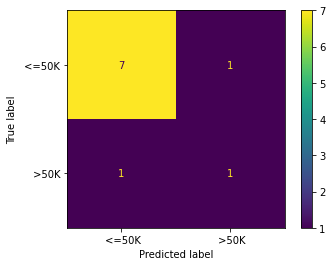

In [182]:
ConfusionMatrixDisplay.from_predictions(data_inf['income_bracket'], y_pred_inf_svc)
plt.show()

Hasil evaluasi pada Inference-Set menunjukan hasil yang lumayan bagus. Kedua model kita menghasilkan nilai precision yang lebih tinggi dibandingkan dengan Train dan Test pada label <=50K, namun memiliki recall yang lebih rendah dibandingkan dengan Train dan Test dimana hal tersebut lebih berbahaya karena orang yang pendapatanya di bawah 50 ribu bisa jadi harus membayar pajak lebih besar dari seharusnya.

# 10 - Kesimpulan

Dataset yang digunakan ini berisi data sensus pendapatan orang dewasa di Amerika. Data ini mengelompokan pendapatan menjadi dua kelompok berbeda yaitu **<=50K dan >50K dollar** dimana data ini menunjukan mayoritas warga Amerika memiliki pendapatan di bawah 50 ribu dollar setahun. Koresponden dalam data ini rata-rata berumur **38 tahun** dan mereka bekerja dengan rata-rata **41 jam seminggu**. Mereka juga memiliki berbagai status yang berbeda, ada yang sudah menikah, ada yang belum menikah, ada yang sudah bercerai, dan lain-lain. Dari data ini kita juga bisa mengetahui ternyata **banyak orang Amerika** yang **belum pernah menjual asetnya** sama sekali. Kita juga bisa melihat bahwa di Amerika ternyata yang bekerja kebanyakan adalah sang **suami** yaitu sebanyak **42%**. Mayoritas warga Amerika dalam data ini yaitu sebanyak **73%** bekerja di **sektor swasta**.

Menggunakan perhitungan korelasi dan berdasarkan personal judgement, kita bisa melihat ada beberapa aspek yang memiliki pengaruh terhadap pendapatan warga Amerika yaitu **umur, lama pendidikan, penjualan aset, lama bekerja seminggu, gender, dan status dalam keluarga**. Dalam kasus ini kita akan lebih **fokus ke label <=50K** karena merupakan orang yang pendapatanya di bawah rata-rata. Kita akan lebih fokus ke bagian recall untuk meminimalisir false negatif karena jika terjadi salah prediksi (false negatif) maka orang yang memiliki pendapatan di bawah rata-rata kemungkinan akan kesulitan jika harus membayar pajak sejumlah orang yang di atas rata-rata atau di atas 50 ribu dollar.

Dari kolom-kolom tersebut, kita membuat 2 model menggunakan Logistic Regression dan SVC. Logistic Regression dengan waktu training lebih sedikit memiliki nilai yang cukup baik namun masih kalah dengan SVC dalam precission, recall, dan accuracy. SVC memiliki accuracy lebih tinggi yaitu **0.84** dimana Logistic Regression hanya **0.83**. Pada label dengan jumlah lebih sedikit yaitu >50K, SVC memiliki precission yang lebih tinggi yaitu **0.76** untuk Train dan Test sedangkan Logistic hanya **0.71** pada Train dan **0.72** pada Test. Pada hal yang kita fokuskan yaitu recall, SVC memiliki nilai **0.94** pada Train dan Test sedangkan Logistic hanya **0.92** di Train dan **0.93** pada Test. Pada Inference Set, kedua model menghasilkan accuracy, recall, dan precission yang sama persis mungkin dikarenakan jumlah Inference yang hanya 10 data.

Jadi dari kedua model yang dibuat, model yang memiliki performa lebih baik adalah **SVC** karena memiliki nilai recall pada label <=50K lebih tinggi dari pada Logistic Regression.



# 11 - Pertanyaan

## Soal 1

Apakah yang dimaksud dengan coeficient pada logistic regression?

Intercept/Coefficient merupakan suatu konstanta yang diperoleh dari rata-rata y (Target) apabila nilai X adalah 0

## Soal 2

Apakah yang dimaksud dengan Support Vector pada SVM?


Support vector merupakan titik data atau titik vektor terluar dari kelompoknya dan paling dekat dengan garis hyperplane, vektor-vektor inilah yang membantu pembuatan garis hyperplane maka dari itu disebut support vector.

## Soal 3

Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

Kernel adalah suatu metode yang digunakan untuk menerima data input dan mentransformasikan ke bentuk yang bisa di proses. Contohnya adalah kernel Poly dimana kernel tersebut akan merubah persamaan linear menjadi persamaan dengan dimensi/derajat lebih tinggi untuk di proses.

sumber : https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/